In [ ]:
import gzip
import json
import pickle

import ipywidgets as widgets
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from ipywidgets import interact
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from teaching_tools.widgets import ConfusionMatrixWidget

Import data

Making the wrangle function, then usung it to import poland-bankruptcy-data-2009.json.gz into the DataFrame df.

In [ ]:
def wrangle(filename):
    with gzip.open(filename, "r") as f:
        data= json.load(f)
    df = pd.DataFrame().from_dict(data["data"]).set_index("company_id")
    return df

In [ ]:
df = wrangle("data/poland-bankruptcy-data-2009.json.gz")
print(df.shape)
df.head()

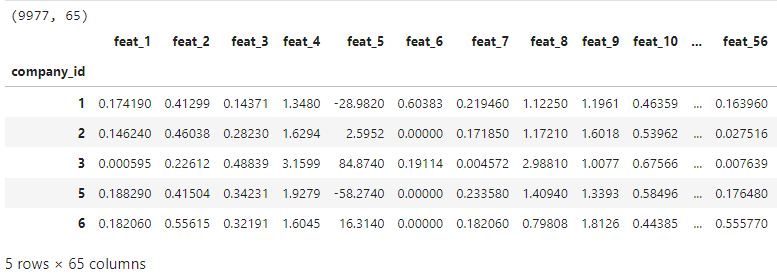

Split

Creating our feature matrix X and target vector y. Our target is "bankrupt"

In [ ]:
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

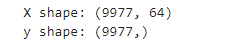

Dividing our data (X and y) into training and test sets using a randomized train-test split. Our test set should be 20% of our total data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state= 42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

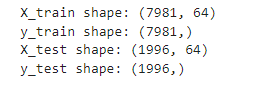

Resample

Creating a new feature matrix X_train_over and target vector y_train_over by performing random over-sampling on the training data

In [ ]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

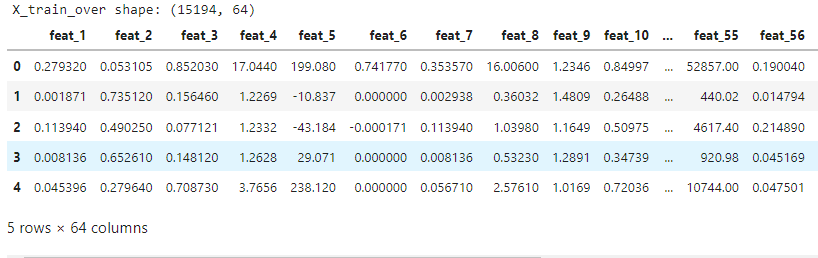

Build Model

Now let's put together our model. We'll start by calculating the baseline accuracy.

Baseline

Calculating the baseline accuracy score for our model.

In [ ]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

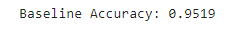

Iterate

Gradient Bossting Trees Model

Creating a pipeline named clf (short for "classifier") that contains a SimpleImputer transformer and a GradientBoostingClassifier predictor.

In [ ]:
clf = make_pipeline(SimpleImputer(), GradientBoostingClassifier())

We only want to be looking at the positive class. Here, the positive class is the one where the companies really did go bankrupt.

Next, we're going to tune some of the hyperparameters for our model.

 Creating a dictionary with the range of hyperparameters that we want to evaluate for our classifier.

In [ ]:
params = {
    "simpleimputer__strategy":["mean", "median"],
    "gradientboostingclassifier__n_estimators":range(20,31,5),
    "gradientboostingclassifier__max_depth": range(2,5)    
}
params

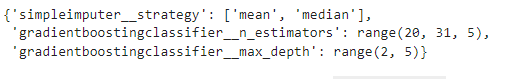

GridSearchCV 

Creating a GridSearchCV named model that includes our classifier and hyperparameter grid. 

In [ ]:
model = GridSearchCV(clf, param_grid=params, cv=5, verbose=1)

Fit model

Now that we have everything we need for the model, let's fit it to the data and see what we've got.


In [ ]:
# Fit model to over-sampled training data
model.fit(X_train_over, y_train_over)

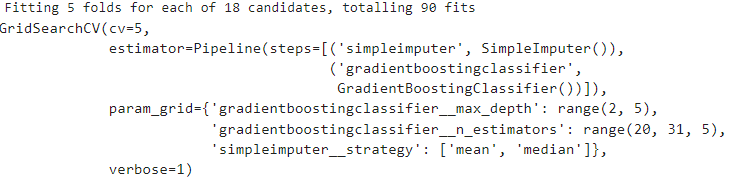

Cv results

Extracting the cross-validation results from model and load them into a DataFrame named cv_results.

In [ ]:
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head(10)

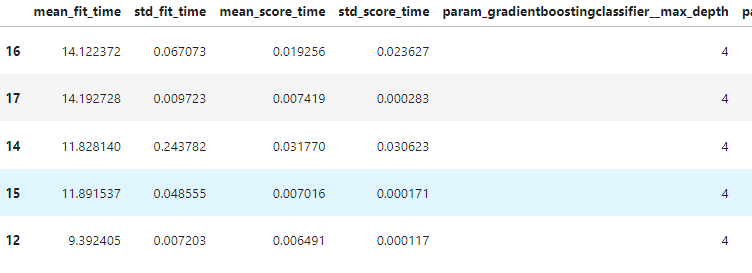

Best Hyperpramaters

There are quite a few hyperparameters there, so let's pull out the ones that work best for our model.

In [ ]:
# Extract best hyperparameters
model.best_params_

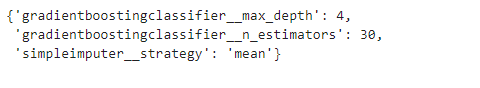

Evaluate

Now that we have a working model that's actually giving us something useful, let's see how good it really is.

Calculating the training and test accuracy scores for model.

In [ ]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

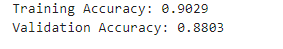

let's make a confusion matrix to see how our model is making its correct and incorrect predictions.


In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

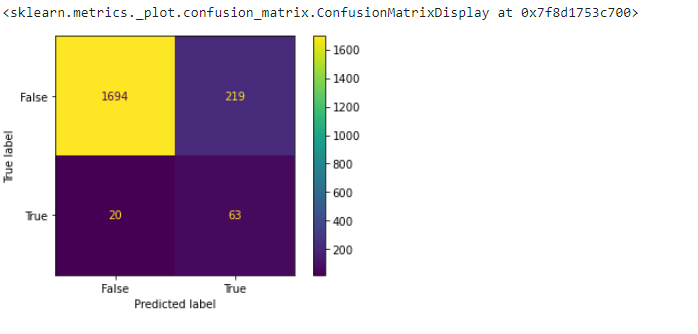

Classification report

This matrix is a great reminder of how imbalanced our data is, and of why accuracy isn't always the best metric for judging whether or not a model is giving us what we want. After all, if 95% of the companies in our dataset didn't go bankrupt, all the model has to do is always predict {"bankrupt": False}, and it'll be right 95% of the time. The accuracy score will be amazing, but it won't tell us what we really need to know.

Instead, we can evaluate our model using two new metrics: precision and recall. The precision score is important when we want our model to only predict that a company will go bankrupt if its very confident in its prediction. The recall score is important if we want to make sure to identify all the companies that will go bankrupt, even if that means being incorrect sometimes.
Let's start with a report we can create with scikit-learn to calculate both metrics.

In [ ]:
# Print classification report
print(classification_report(y_test, model.predict(X_test)))

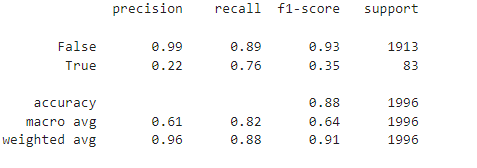

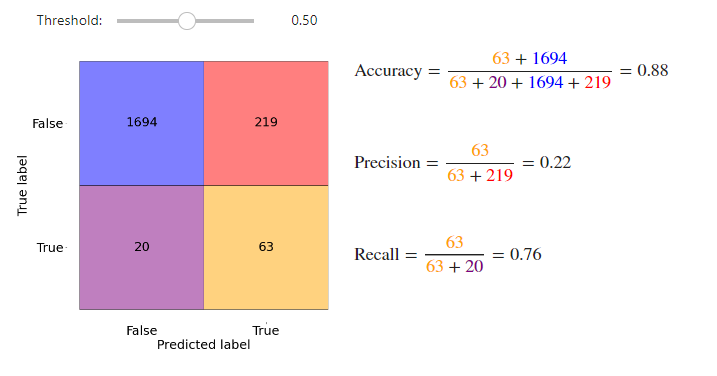

Creating an interactive dashboard that shows how company profit and losses change in relationship to our model's probability threshold. Starting with the make_cnf_matrix function, which should calculate and print profit/losses, and display a confusion matrix. Then creating a FloatSlider thresh_widget that ranges from 0 to 1. Finally combining our function and slider in the interact function.

In [ ]:
def make_cnf_matrix(threshold):
    y_pred_proba = model.predict_proba(X_test)[:, -1]
    y_pred = y_pred_proba > threshold
    conf_matrix= confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    print(f"Profit:€{tp * 100_000_000}")
    print(f"Losses:€{fp * 250_000_000}")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False)

thresh_widget = widgets.FloatSlider(min=0, max=1, value=0.5, step=0.05)

interact(make_cnf_matrix, threshold=thresh_widget);

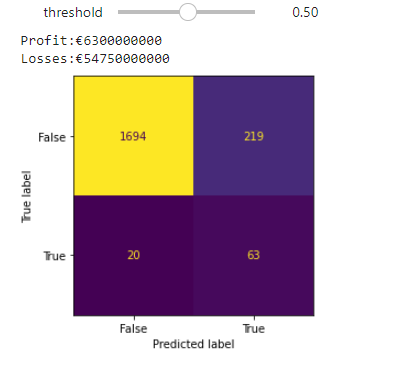

Related to the model we can focus on precision or recall. 